# КТ 2: Выбросы CO2 автомобилями

**Задание**: Необходимо провести разведочный анализ данных и применить изученные модели (не обязательно все), добившись наилучшего качества прогноза на тестовой выборке. Необходимо выбрать метрику, обосновав выбор. 

Необходимо подготовить файл формата ipynb такой, что бы в нем были описаны все этапы решения задачи, где это возможно, визуализированы, а также написаны комментарии. 

**Датасет**: 'CO2 emission of cars.csv'.

**Целевая переменная**: CO2.

Описание датасета 'CO2 emission of cars.csv':

| Название | Перевод |
| --- | --- |
| Car | Фирма автомобиля |
| Model | Модель |
| Volume | Объем |
| Weight | Вес |
| _**CO2**_ | _**Выбросы углекислого газа**_ |

## <a class="anchor" id="0"></a> <b>Оглавление<b/>

* [Знакомство с данными и предобработка](#1)
* [Визуализация](#2)
* [Модели](#3)
* [Дополнительно](#4)

## <a class="anchor" id="1"></a> 1. Знакомство с данными и предобработка

[Оглавление](#0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

Импортировали нужные библиотеки и модули. Загрузим датасет.

In [2]:
data = pd.read_csv('CO2 emission of cars.csv')
data.head()

,Car,Model,Volume,Weight,CO2,Unnamed: 5
0,Toyota,Aygo,1000,790,99,NaN
1,Mitsubishi,Space Star,1200,1160,95,NaN
2,Skoda,Citigo,1000,929,95,NaN
3,Fiat,500,900,865,90,NaN
4,Mini,Cooper,1500,1140,105,NaN


Познакомимся с данными и займемся предобработкой.

In [3]:
data = data.drop({'Unnamed: 5'}, axis=1) # уберем столбец, не несущий информации
data.columns = data.columns.str.lower() # для удобства переведем названия столбцов в нижний регистр

data.head()

,car,model,volume,weight,co2
0,Toyota,Aygo,1000,790,99
1,Mitsubishi,Space Star,1200,1160,95
2,Skoda,Citigo,1000,929,95
3,Fiat,500,900,865,90
4,Mini,Cooper,1500,1140,105


In [4]:
data.shape

(36, 5)

In [5]:
data.size

180

Проверим верность типов данных, наличие пропусков и дубликатов.

In [6]:
data.info() # проверяем тип данных (проблем нет); пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   car     36 non-null     object
 1   model   36 non-null     object
 2   volume  36 non-null     int64 
 3   weight  36 non-null     int64 
 4   co2     36 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 1.5+ KB


In [7]:
data.isna().sum()  # пропусков точно нет

car       0
model     0
volume    0
weight    0
co2       0
dtype: int64

In [8]:
data.duplicated().sum() # дубликатов нет

0

Общая характеристика количественных столбцов (до работы с выбросами).

In [9]:
data.describe()

,volume,weight,co2
count,36.000000,36.000000,36.000000
mean,1611.111111,1292.277778,102.027778
std,388.975047,242.123889,7.454571
min,900.000000,790.000000,90.000000
25%,1475.000000,1117.250000,97.750000
50%,1600.000000,1329.000000,99.000000
75%,2000.000000,1418.250000,105.000000
max,2500.000000,1746.000000,120.000000


Проверим уникальные значения. у столбца 'car', очевидно, у фирмы бывают разные модели машин.

In [10]:
data['car'].nunique()

17

Заметим, что всего строк 36, а уникальных моделей - 35. Рассмотрим это подробнее.

In [11]:
data['model'].nunique()

35

Видим, что все модели встречаются один раз, кроме "Fiesta":

In [12]:
data['model'].value_counts().head()

model
Fiesta      2
Aygo        1
A6          1
Insignia    1
C-Class     1
Name: count, dtype: int64

In [13]:
data[data['model']=='Fiesta']

,car,model,volume,weight,co2
8,Ford,Fiesta,1500,1112,98
12,Ford,Fiesta,1000,1112,99


Видим, что почти значения в столбцах либо полностью, либо почти полностью совпадают.

Скорее всего, это не дубликат. У машин может быть одна и та же модель (в нашем случае - Ford Fiesta), но с разными конфигурациями двигателя, и это абсолютно нормально и возможно.

Посмотрим на корреляцию (до работы с выбросами).

In [14]:
# корреляционная матрица (только с количественными признаками)
correlation_matrix = data.corr(numeric_only=True)
correlation_matrix

,volume,weight,co2
volume,1.000000,0.753537,0.592082
weight,0.753537,1.000000,0.552150
co2,0.592082,0.552150,1.000000


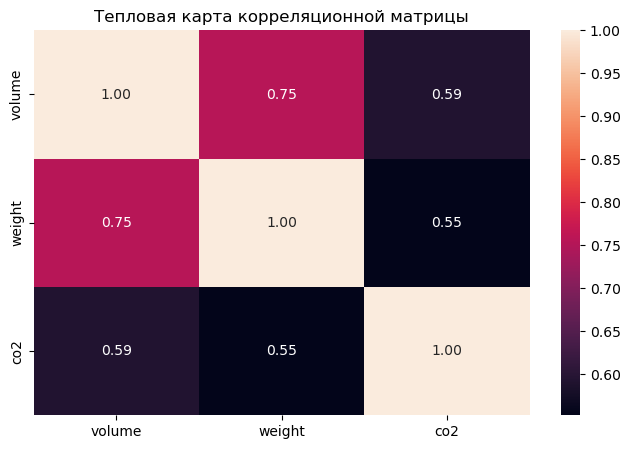

In [15]:
# рассмотрим подробнее
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Тепловая карта корреляционной матрицы')
plt.show()

Далее, проверим наличие выбросов.

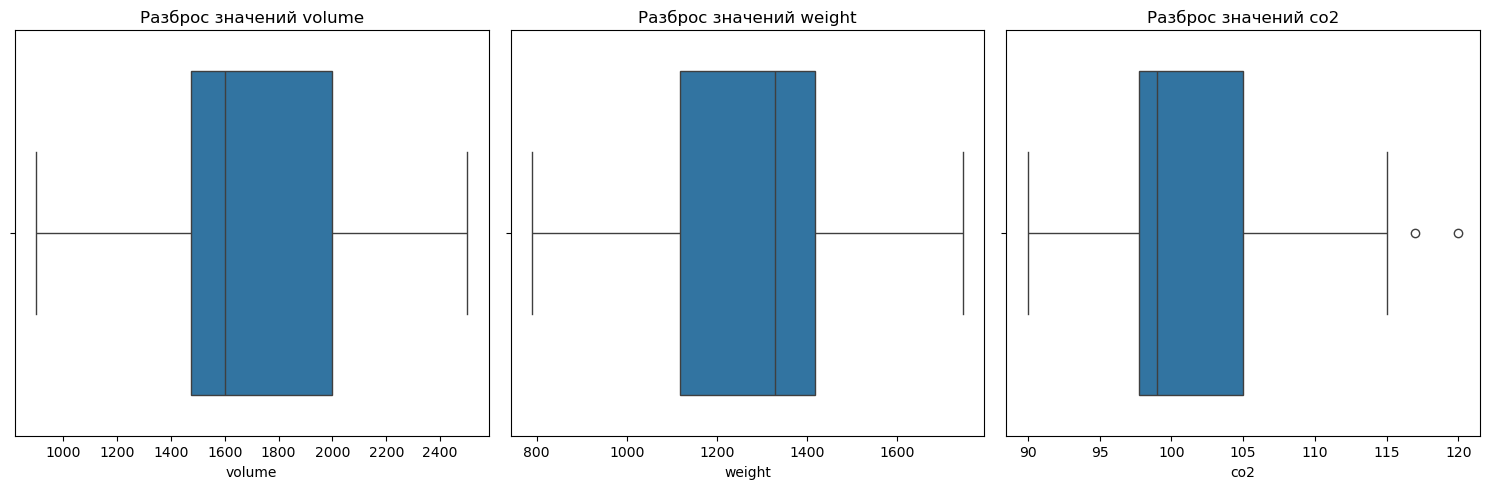

In [16]:
# столбцы с количественными значениями
num_columns = ['volume', 'weight', 'co2']
n_cols = len(num_columns)

# графики в один ряд
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(5 * n_cols, 5))

# ящики с усами (боксплот) (в горизонтальном виде)
for i, col in enumerate(num_columns):
    sns.boxplot(data=data, x=col, ax=axes[i], orient='h')
    axes[i].set_title(f'Разброс значений {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

Заметим, что есть два (2) выброса в столбце CO2. Исключим их из датасета.

In [17]:
# разберемся с выбросами через IQR
q1 = data['co2'].quantile(0.25) # первый квартиль (или нижний квартиль) Q1 определяется как значение, отделяющее первую четверть выборки(в нашем случае - датасета)
q3 = data['co2'].quantile(0.75) # третий квартиль - Q3 - определяется как значение, отделяющее три четверти выборки(в нашем случае - датасета)
iqr = q3 - q1 # расстояние Q3-Q1 называют - межквартильный размах IQR

# длина усов - 1.5 IQR; значения за пределами усов - выбросы
# т.е. границы выбросов
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

# выбросы. все, что выходит за рамки усов
out_of_iqr = len(data[(data['co2'] < lower_bound) | (data['co2'] > upper_bound)])
proportion = out_of_iqr / len(data) * 100
print(f'Количество выбросов: {out_of_iqr}.\nДоля выбросов от всех данных: {proportion:.3f}%.')

Количество выбросов: 2.
Доля выбросов от всех данных: 5.556%.


In [18]:
data[(data['co2'] < lower_bound) | (data['co2'] > upper_bound)] # что же выходит за рамки усов - наши выбросы

,car,model,volume,weight,co2
31,Volvo,XC70,2000,1746,117
35,Mercedes,SLK,2500,1395,120


In [19]:
print(f'Среднее значение CO2 до исключения выбросов: {data['co2'].mean():.3f};\nМедиана CO2 до исключения выбросов: {data['co2'].median()}.')

Среднее значение CO2 до исключения выбросов: 102.028;
Медиана CO2 до исключения выбросов: 99.0.


In [20]:
# удалим выбросы
data = data[(data['co2'] >= lower_bound) & (data['co2'] <= upper_bound)]
print(f'Датафрейм БЕЗ выбросов: {len(data)} строки.')

Датафрейм БЕЗ выбросов: 34 строки.


In [21]:
print(f'Среднее значение CO2 после исключения выбросов: {data['co2'].mean()};\nМедиана CO2 после исключения выбросов: {data['co2'].median()}.')

Среднее значение CO2 после исключения выбросов: 101.05882352941177;
Медиана CO2 после исключения выбросов: 99.0.


## Вывод:

* Импортировали нужные библиотеки и загрузили данные, с которыми будем работать.
* Убрали лишний столбец.
* Поменяли регистр столбцов для более удобного формата.
* Типы данных столбцов указаны верно, нет пропусков, нет дубликатов.
* Заметили интересный момент: машины одной фирмы и модели могут иметь отличия в характеристиках в силу различий в конфигурации двигателя.
* Построили таблицу с общей характеристикой числовых столбцов и корреляционную матрицу ДО работы с выбросами.
* Построили ящики с усами (боксплоты), обнаружили два (2) выброса (в столбце CO2) и исключили их с помощью метода межквартильного размаха (IQR).

## <a class="anchor" id="2"></a> 2. Визуализация

[Оглавление](#0)

Ранее, помимо построения ящиков с усами для поиска выбросов, мы строили корреляционную матрицу и ее визуалиацию (до работы с выбросами), а также таблицу describe (до работы с выбросами).

Изучим то, как они изменились после предобработки. А также визуализируем другую информацию из датасета.

Итак, общая характеристика количественных столбцов (после работы с выбросами).

In [22]:
data.describe()

,volume,weight,co2
count,34.000000,34.000000,34.000000
mean,1573.529412,1275.911765,101.058824
std,361.234268,235.250784,6.433535
min,900.000000,790.000000,90.000000
25%,1425.000000,1113.750000,97.250000
50%,1600.000000,1327.000000,99.000000
75%,1900.000000,1415.000000,104.750000
max,2200.000000,1725.000000,115.000000


Как было отмечено ранее, количество данных уменьшилось на 2 (два выброса были исключены), поэтому теперь count - 34, а не 36. Также, как ранее было описано, изменилось среднее (причем по всем столбцам). Остальные характеристики также немного изменились, единственная характеристика без изменений - минимальное значение по каждому столбцу. Это очевидно, ведь выбросы были лишь те, что превышали "усы" (а не выходили за нижнюю границу).

Рассмотрим корреляцию (после работы с выбросами).

In [23]:
# корреляционная матрица (только с количественными признаками)
correlation_matrix = data.corr(numeric_only=True)
correlation_matrix

,volume,weight,co2
volume,1.000000,0.782788,0.483137
weight,0.782788,1.000000,0.514606
co2,0.483137,0.514606,1.000000


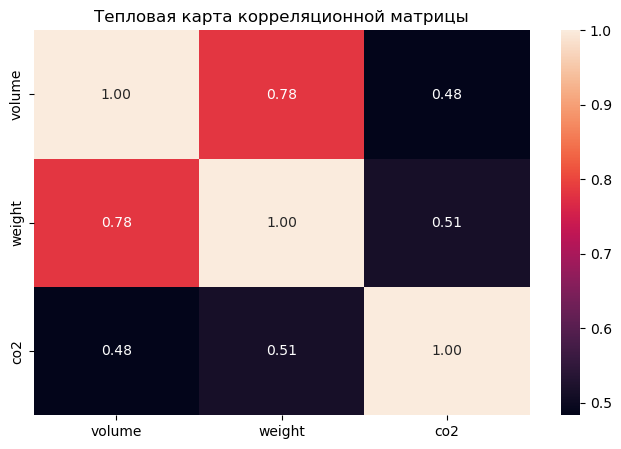

In [24]:
# рассмотрим подробнее
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Тепловая карта корреляционной матрицы')
plt.show()

Итак,
* Заметим, что корреляция между объемом и весом увеличилась (было: 0.75, стало: 0.78).
* Корреляция между CO2 и объемом уменьшилась (было: 0.59, стало: 0.48).
* Корреляция между CO2 и весом также уменьшилась (было: 0.55, стало: 0.51).

Это изменение показывает, что межфакторная связь между независимыми переменными стала еще сильнее, чем была. Тем более, по сравнению с связью с фактором-результатом. Есть шанс подозревать мультиколлинеарность.

Визуализируем другую информацию из датасета.

Рассмотрим, какие фирмы чаще встречаются в датасете.

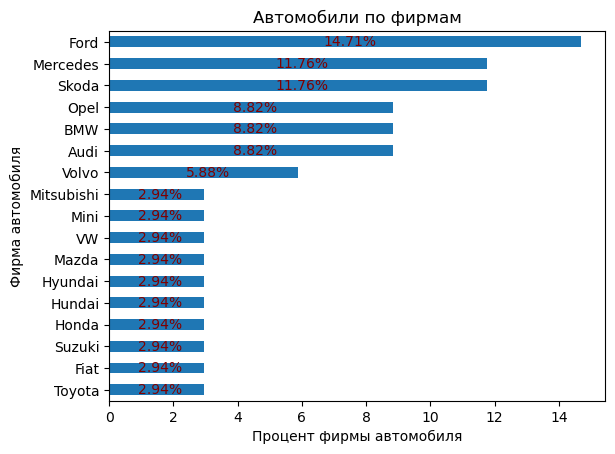

In [25]:
# группировка автомобилей по фирмам
data_car = data.groupby('car').agg(count_car=('car', 'count')).reset_index()
data_car['perc_car'] =  (data_car['count_car']/data_car['count_car'].sum()) * 100

# столбчатая диаграмма автомобилей по фирмам
ax_car = data_car.sort_values(by='perc_car', ascending=True).plot(
                kind='barh',
                legend=False,
                x='car',
                y='perc_car',                               
                title='Автомобили по фирмам',
                xlabel='Процент фирмы автомобиля',
                ylabel='Фирма автомобиля'
                )
ax_car.bar_label(ax_car.containers[0],fmt='%.2f%%',padding=3, label_type='center', color='maroon')
plt.show()

Отметим, что больше всего в датасете машин фирмы Ford, Mercedes и Scoda.

Рассмотрим распределение значений по количественным столбцам.

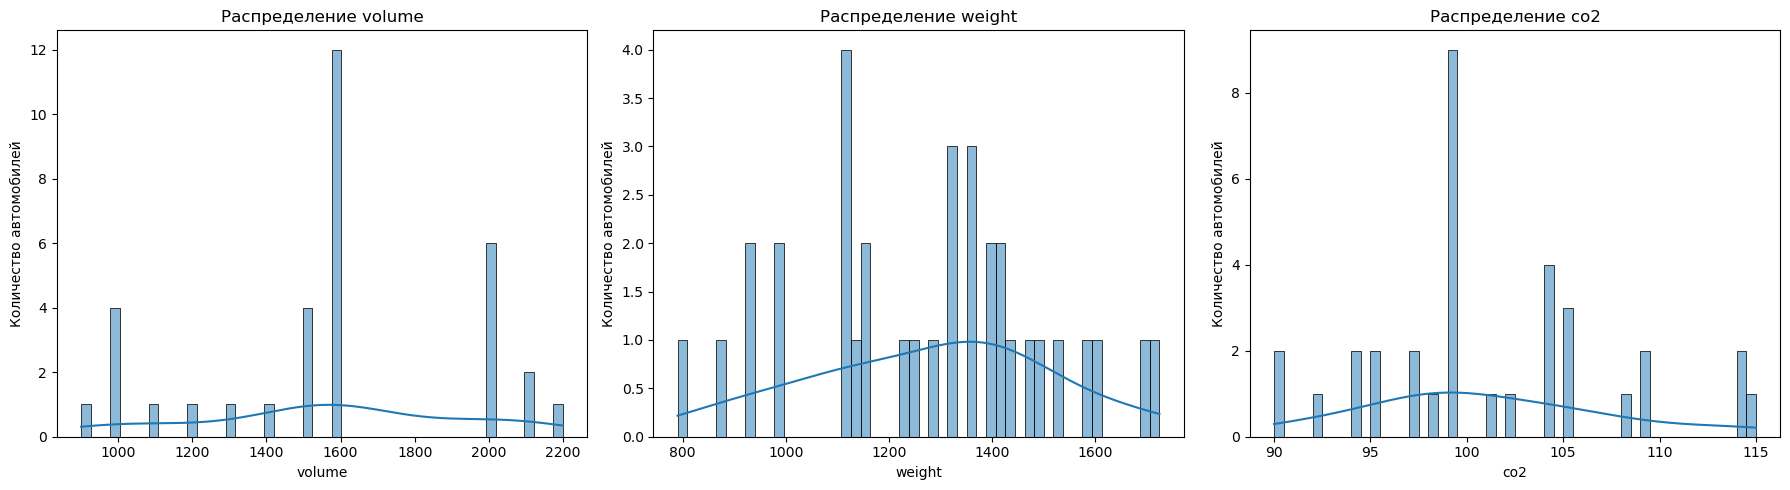

In [26]:
# графики в один ряд
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(6 * n_cols, 5))

# цикл по столбцам
for i, col in enumerate(num_columns):
    sns.histplot(data[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Количество автомобилей')

plt.tight_layout()
plt.show()

Построим "парные диаграммы" (пеирплот). Pairplot используется для сравнения распределения пар числовых переменных, он создаёт сетку точечных диаграмм. Он также содержит гистограмму для каждой функции в диагональных прямоугольниках (по сути повторяет часть графиков выше).

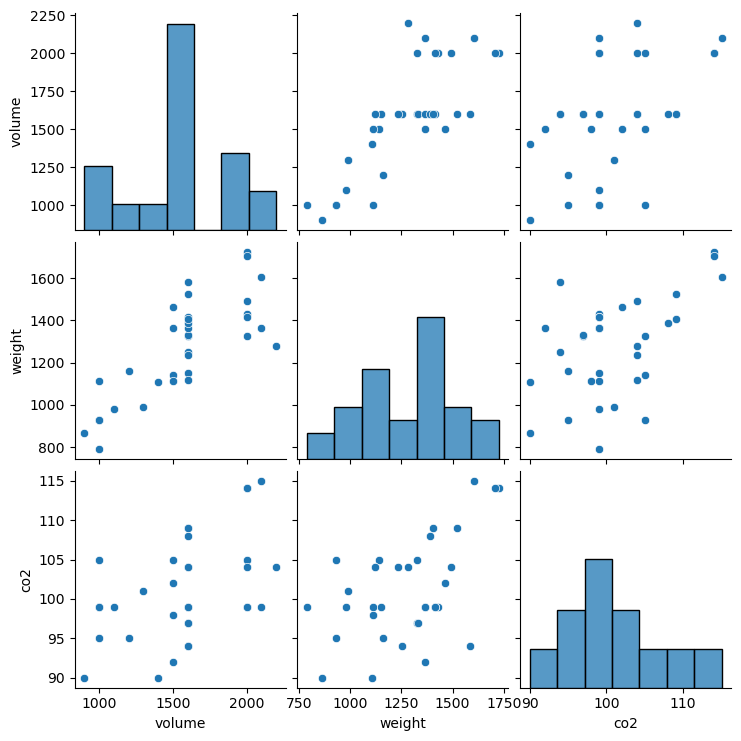

In [27]:
sns.pairplot(data)

Стоит отметить, что датасет - маленький (меньше 40 строк), из-за чего визуализация может выглядеть скудно.

## Вывод:

* Построили таблицу с общей характеристикой числовых столбцов и корреляционную матрицу ПОСЛЕ работы с выбросами.
* Рассмотрели то, как они изменились по сравнению с первым этапом работы.
* Выяснили то, какие фирмы чаще всего встречаются в датасете.
* Посмотрели распределение объема, веса и углекислого газа.
* Построили "парные диаграммы" (пеирплот) для количественных столбцов (объем, вес, выбросы углекислого газа).

## <a class="anchor" id="3"></a> 3. Модели

[Оглавление](#0)

В качестве метрик были выбраны MAE И RMSE, поскольку датасет очень маленький и в нем нет выбросов.

Если разница между MAE  и RMSE небольшая, то значит модель не сильно "ошибается на отдельных точках".

<div style="background-color:#FCE5CD; padding: 6px; border: 4px solid #D9D2E9;">
<div style="background-color:#FCE5CD; padding: 6px; border: 4px solid #D9D2E9;">
Наилучшая модель выделена цветом.

### Модели только с количественными признаками

В процессе перебора моделей оказалось, что масштабирование количественнных данных не влияет на модель (пробовалась стандартизация StandardScaler), поэтому ниже нигде ее не будет. 

Также, перебирались модели, где есть оба (и volume, и weight) количественных признака, и только volume - самые лучшие результаты показали модели с weight. Чего и стоило ожидать, если вспомнить корреляционную матрицу после работы с выбросами.

#### LinearRegression

MAE: 3.465
RMSE: 4.086


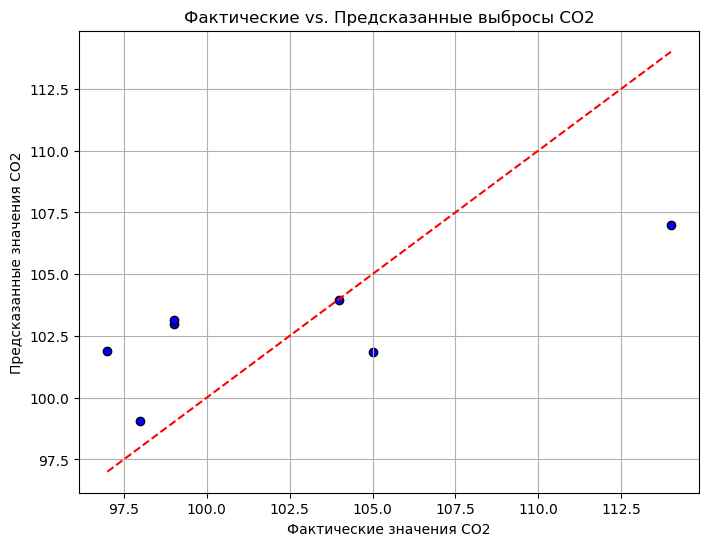

In [28]:
# из признаков - только weight (количественная переменная)
X = data[['weight']] # признак
y = data[['co2']] # целевая переменная

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42) # 20/80

x_train=train_X
x_test=test_X

# !
reg = LinearRegression().fit(x_train, train_y)

pred = reg.predict(x_test)
# метрики
r2 = r2_score(test_y, pred)
mae = mean_absolute_error(test_y, pred)
mse = mean_squared_error(test_y, pred)
rmse = root_mean_squared_error(test_y, pred)
mape = mean_absolute_percentage_error(test_y, pred)

print(f'MAE: {round(mae,3)}\nRMSE: {round(rmse,3)}')

# график фактические и предсказанные выбросы углекислого газа
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, color='blue', edgecolors='k')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--') 
plt.xlabel("Фактические значения CO2")
plt.ylabel("Предсказанные значения CO2")
plt.title("Фактические vs. Предсказанные выбросы CO2")
plt.grid(True)
plt.show()

<div style="background-color:#FCE5CD; padding: 6px; border: 4px solid #D9D2E9;">
<div style="background-color:#FCE5CD; padding: 6px; border: 4px solid #D9D2E9;">

#### DecisionTreeRegressor

MAE: 1.571
RMSE: 3.14


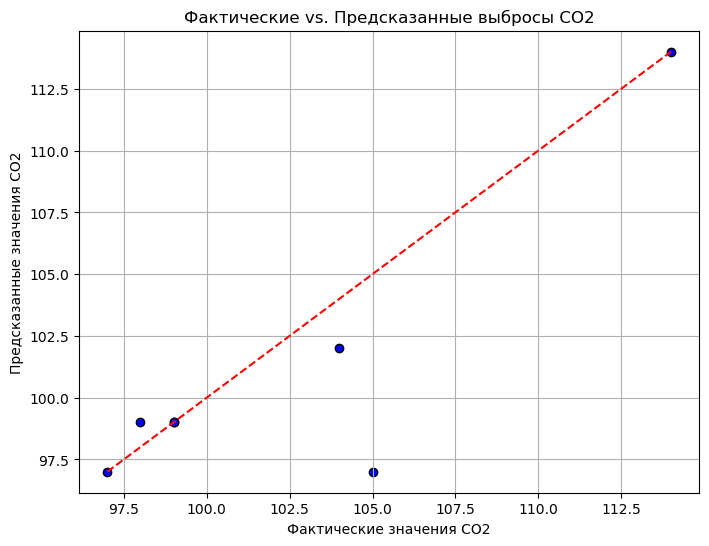

In [29]:
# из признаков - только weight (количественная переменная)
X = data[['weight']] # признак
y = data[['co2']] # целевая переменная

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42) # 20/80

x_train=train_X
x_test=test_X

# !
decision_tree_reg = DecisionTreeRegressor().fit(x_train, train_y)

pred = decision_tree_reg.predict(x_test)
# метрики
r2 = r2_score(test_y, pred)
mae = mean_absolute_error(test_y, pred)
mse = mean_squared_error(test_y, pred)
rmse = root_mean_squared_error(test_y, pred)
mape = mean_absolute_percentage_error(test_y, pred)


print(f'MAE: {round(mae,3)}\nRMSE: {round(rmse,3)}')

# график фактические и предсказанные выбросы углекислого газа
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, color='blue', edgecolors='k')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--') 
plt.xlabel("Фактические значения CO2")
plt.ylabel("Предсказанные значения CO2")
plt.title("Фактические vs. Предсказанные выбросы CO2")
plt.grid(True)
plt.show()

<div style="background-color:#FCE5CD; padding: 6px; border: 4px solid #D9D2E9;">
<div style="background-color:#FCE5CD; padding: 6px; border: 4px solid #D9D2E9;">
В среднем модель ошибается на 1.571 граммов CO2, а типичная ошибка с учётом крупных отклонений — 3.14 граммов CO2. Эта модель - лучшая модель по обеим метрикам. Она обеспечивает наиболее точный и стабильный прогноз выбросов CO2 среди рассмотренных вариантов.

### Модели с количественными и категориальными признаками

Хотя рекомендуется кодировать категориальные переменные после разбиения для избежания утечки данных, попробуем разные варианты.

### Кодирование после разбиения

#### LinearRegression

MAE: 6.133
RMSE: 7.161


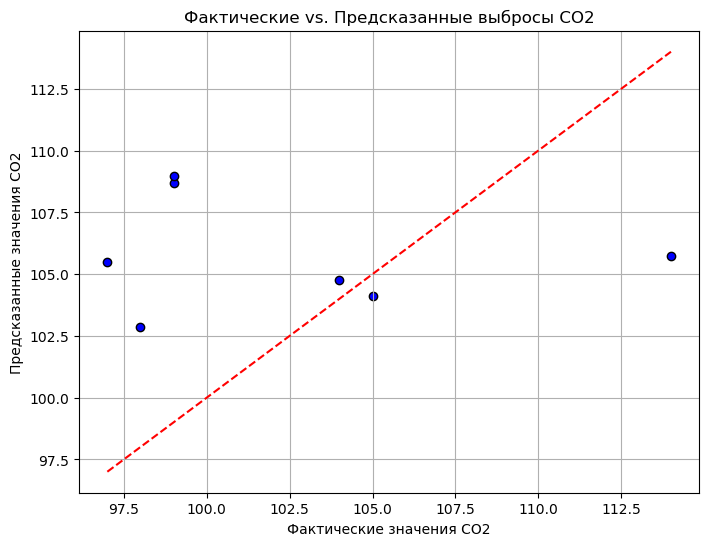

In [30]:
# из признаков - все (и количественные, и категориальные), кодирование после разбиения
X = data.drop(columns=['co2']) # признаки
y = data[['co2']] # целевая переменная

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# присттупим к кодированию категориальных переменных
categ_columns = train_X.select_dtypes(include=['object']).columns
numer_columns = train_X.select_dtypes(exclude=['object']).columns
# поскольку они не имеют иерархии (фирмы и модели), то воспользуемся OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# обучаем только на train
train_cat = ohe.fit_transform(train_X[categ_columns])
train_cat_df = pd.DataFrame(train_cat, columns=ohe.get_feature_names_out(categ_columns), index=train_X.index)
# трансформируем test с тем же енкодером
test_cat = ohe.transform(test_X[categ_columns])
test_cat_df = pd.DataFrame(test_cat, columns=ohe.get_feature_names_out(categ_columns), index=test_X.index)

# объединяем обратно с количественными признаками
train_X_encoded = pd.concat([train_X[numer_columns].reset_index(drop=True), train_cat_df.reset_index(drop=True)], axis=1)
test_X_encoded = pd.concat([test_X[numer_columns].reset_index(drop=True), test_cat_df.reset_index(drop=True)], axis=1)

# !
reg = LinearRegression().fit(train_X_encoded, train_y)

pred = reg.predict(test_X_encoded)

# метрики
r2 = r2_score(test_y, pred)
mae = mean_absolute_error(test_y, pred)
mse = mean_squared_error(test_y, pred)
rmse = root_mean_squared_error(test_y, pred)
mape = mean_absolute_percentage_error(test_y, pred)

print(f'MAE: {round(mae,3)}\nRMSE: {round(rmse,3)}')

# график фактические и предсказанные выбросы углекислого газа
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, color='blue', edgecolors='k')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--') 
plt.xlabel("Фактические значения CO2")
plt.ylabel("Предсказанные значения CO2")
plt.title("Фактические vs. Предсказанные выбросы CO2")
plt.grid(True)
plt.show()

#### DecisionTreeRegressor

MAE: 4.857
RMSE: 6.437


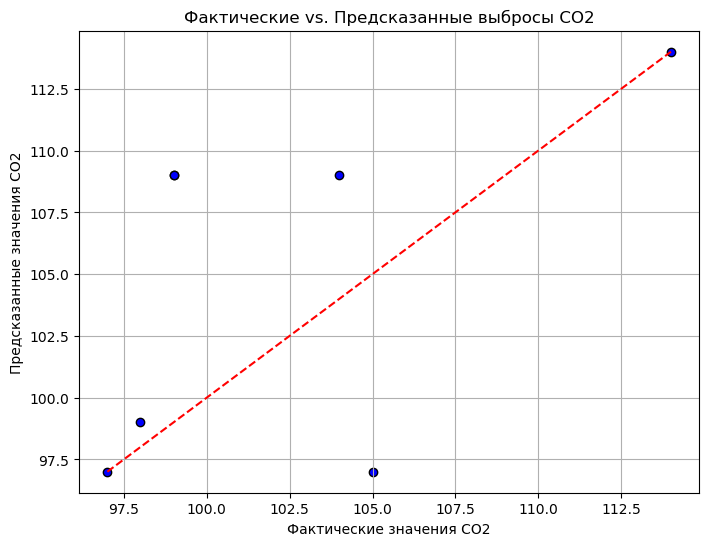

In [31]:
# из признаков - все (и количественные, и категориальные), кодирование после разбиения
X = data.drop(columns=['co2']) # признаки
y = data[['co2']] # целевая переменная

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# присттупим к кодированию категориальных переменных
categ_columns = train_X.select_dtypes(include=['object']).columns
numer_columns = train_X.select_dtypes(exclude=['object']).columns
# поскольку они не имеют иерархии (фирмы и модели), то воспользуемся OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# обучаем только на train
train_cat = ohe.fit_transform(train_X[categ_columns])
train_cat_df = pd.DataFrame(train_cat, columns=ohe.get_feature_names_out(categ_columns), index=train_X.index)
# трансформируем test с тем же енкодером
test_cat = ohe.transform(test_X[categ_columns])
test_cat_df = pd.DataFrame(test_cat, columns=ohe.get_feature_names_out(categ_columns), index=test_X.index)

# объединяем обратно с количественными признаками
train_X_encoded = pd.concat([train_X[numer_columns].reset_index(drop=True), train_cat_df.reset_index(drop=True)], axis=1)
test_X_encoded = pd.concat([test_X[numer_columns].reset_index(drop=True), test_cat_df.reset_index(drop=True)], axis=1)

# !
decision_tree_reg = DecisionTreeRegressor().fit(train_X_encoded, train_y)

pred = decision_tree_reg.predict(test_X_encoded)

# метрики
r2 = r2_score(test_y, pred)
mae = mean_absolute_error(test_y, pred)
mse = mean_squared_error(test_y, pred)
rmse = root_mean_squared_error(test_y, pred)
mape = mean_absolute_percentage_error(test_y, pred)

print(f'MAE: {round(mae,3)}\nRMSE: {round(rmse,3)}')

# график фактические и предсказанные выбросы углекислого газа
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, color='blue', edgecolors='k')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--') 
plt.xlabel("Фактические значения CO2")
plt.ylabel("Предсказанные значения CO2")
plt.title("Фактические vs. Предсказанные выбросы CO2")
plt.grid(True)
plt.show()

### Кодирование до разбиения

#### LinearRegression

MAE: 6.133
RMSE: 7.161


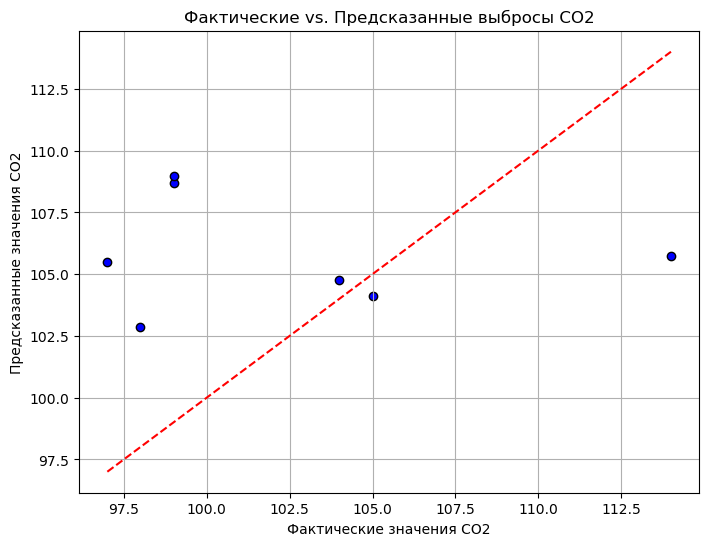

In [32]:
# из признаков - все (и количественные, и категориальные), LinearRegression, кодирование до разбиения

# сначала закодируем
df = data.copy() # чтобы издеваться над копией датасета
one_enc = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    ohe = OneHotEncoder(sparse_output=False, drop=None)
    encoded_features = ohe.fit_transform(df[[col]])
    encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out([col]))
    encoded_df.index = df.index
    
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(col, axis=1, inplace=True)
    one_enc[col] = ohe


X = df.drop(['co2'], axis=1) # признаки
y = df[['co2']] # целевая переменная

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42) # 20/80

x_train=train_X
x_test=test_X

reg = LinearRegression().fit(x_train, train_y)

pred = reg.predict(x_test)
# метрики
r2 = r2_score(test_y, pred)
mae = mean_absolute_error(test_y, pred)
mse = mean_squared_error(test_y, pred)
rmse = root_mean_squared_error(test_y, pred)
mape = mean_absolute_percentage_error(test_y, pred)

print(f'MAE: {round(mae,3)}\nRMSE: {round(rmse,3)}')

# график фактические и предсказанные выбросы углекислого газа
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, color='blue', edgecolors='k')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--') 
plt.xlabel("Фактические значения CO2")
plt.ylabel("Предсказанные значения CO2")
plt.title("Фактические vs. Предсказанные выбросы CO2")
plt.grid(True)
plt.show()

#### DecisionTreeRegressor

MAE: 5.571
RMSE: 6.814


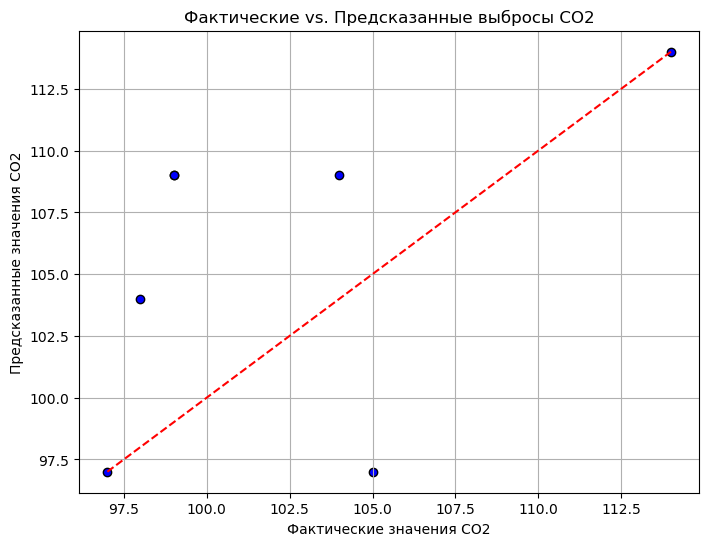

In [33]:
# сначала закодируем
df = data.copy() # чтобы издеваться над копией датасета
one_enc = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    ohe = OneHotEncoder(sparse_output=False, drop=None)
    encoded_features = ohe.fit_transform(df[[col]])
    encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out([col]))
    encoded_df.index = df.index
    
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(col, axis=1, inplace=True)
    one_enc[col] = ohe


X = df.drop(['co2'], axis=1) # признаки
y = df[['co2']] # целевая переменная

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42) # 20/80

x_train=train_X
x_test=test_X

# !
decision_tree_reg = DecisionTreeRegressor().fit(x_train, train_y)

pred = decision_tree_reg.predict(x_test)
# метрики
r2 = r2_score(test_y, pred)
mae = mean_absolute_error(test_y, pred)
mse = mean_squared_error(test_y, pred)
rmse = root_mean_squared_error(test_y, pred)
mape = mean_absolute_percentage_error(test_y, pred)

print(f'MAE: {round(mae,3)}\nRMSE: {round(rmse,3)}')

# график фактические и предсказанные выбросы углекислого газа
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, color='blue', edgecolors='k')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--') 
plt.xlabel("Фактические значения CO2")
plt.ylabel("Предсказанные значения CO2")
plt.title("Фактические vs. Предсказанные выбросы CO2")
plt.grid(True)
plt.show()

## Вывод:

* Рассмотрели различные модели и нашли лучшую в соответствии с выбранными метриками.
* В процессе рассмотрения моделей с количественными признаками выяснили, что стандартизация не меняет метрики модели для нашего датасета.
* Также в процессе рассмотрения моделей с количественными признаками подтвердилась гипотеза о том, что модель с признаком weight оказалась самой точной (гипотеза была - при рассмотернии корреляционной матрицы)
* Рассмотрели модели с количественными признаками - как линейную регрессию, так и дерево решений
* Рассмотрели модели с кодированием категориальных переменных - причем как до разбиения датасета на тестовую и обучающую выборки, так и после.
* Для каждой модели построили график фактических и предсказанных значений.

## <a class="anchor" id="4"></a> 4. Дополнительно

[Оглавление](#0)

Не относится к заданию, но была создана система фильтрации с помощью gradio для красивого вывода датасета.

(Если не загрузится в ячейках тут, есть ссылки, по ним можно перейти и запустится)

In [34]:
import gradio as gr

In [36]:
# для слайдеров нужен float64
df = data.copy()
df = df.astype({'volume': 'float64', 'weight': 'float64', 'co2': 'float64'})

# уникальные значения для селекторов
car_type_options = df['car'].unique().tolist()
model_type_options = df['model'].unique().tolist()

# диапазоны для слайдеров
volume_range = (df['volume'].min(), df['volume'].max())
weight_range = (df['weight'].min(), df['weight'].max())
co2_range = (df['co2'].min(), df['co2'].max())

# фильтр
def filtered_data(car_type, model_type, volume_amount, weight_amount, co2_amount):
    filtered_df = df.copy()
    if car_type:
        filtered_df = filtered_df[filtered_df['car'] == car_type]
    if model_type:
        filtered_df = filtered_df[filtered_df['model'] == model_type]
    filtered_df = filtered_df[
        (filtered_df['volume'] <= volume_amount) &
        (filtered_df['weight'] <= weight_amount) &
        (filtered_df['co2'] <= co2_amount)]
    
    return filtered_df

# сброс фильтров
def reset_filters():
    return None, None, volume_range[1], weight_range[1], co2_range[1], df

# цвет оформления
theme = gr.themes.Default(primary_hue='purple').set(
    loader_color='#E6E6FA',
    slider_color='#D8BFD8',
    button_primary_background_fill='#E6E6FA',
    button_primary_background_fill_hover='#D8BFD8')

# интерфейс таблицы с фмльтрами
with gr.Blocks(theme=theme) as demo:
    gr.Markdown("""
    # Выбросы углекислого газа автомобилями  
    Выберите характеристики, чтобы найти подходящие машины
    """)
    
    with gr.Row():
        car_type = gr.Dropdown(choices=car_type_options, label='Машина')
        model_type = gr.Dropdown(choices=model_type_options, label='Модель машины')
        
        volume_amount = gr.Slider(minimum=volume_range[0], maximum=volume_range[1], label='Объем', value=volume_range[1])
        weight_amount = gr.Slider(minimum=weight_range[0], maximum=weight_range[1], label='Вес', value=weight_range[1])
        co2_amount = gr.Slider(minimum=co2_range[0], maximum=co2_range[1], label='CO2', value=co2_range[1])

    #  кнопочки
    filter_button = gr.Button("Фильтровать")
    reset_button = gr.Button("Сбросить фильтр")
    output_df = gr.DataFrame(headers=list(df.columns), type='pandas')
    filter_button.click(
        fn=filtered_data,
        inputs=[car_type, model_type, volume_amount, weight_amount, co2_amount],
        outputs=output_df)
    reset_button.click(
        fn=reset_filters,
        inputs=[],
        outputs=[car_type, model_type, volume_amount, weight_amount, co2_amount, output_df])

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://764391065863ca352f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Вывод:

* Красиво :)